# Using Mazo

```yaml
Course:   DS 5001
Module:   08a Lab
Topic:    Using Mazo
Author:   R.C. Alvarado
Date:     23 March 2023
```

## Purpose

Demonstrate utility of Mazo output.

We run mazo on a demo corpus, then we convert the results to dataframes and store them in a SQLite database.

## Before Using This Notebook

1. **Download Mazo** from https://github.com/ontoligent-design/mazo. \
   Create the repo in your `DS5001` directory. \
   Or you can use the source code that exists in the course repo's `local_lib` under `lessons`. \
   *You should already have MALLET installed on your system and know where it is.*
3. **Install Mazo** using `pip install .` from within the repo directory (it should have a `setup.py` file in it).
4. **Create a project directory**, e.g. `mazo-demo`, somewhere outside of the repo directory.\
   In this new directory, do the following:
   - Create a subdirectory called `corpus`.
   - Create a subdirectory called `output`
   - Copy `config-demo.ini` from the repo directory into your new directory and rename it to `config.ini`.
   - Copy `demo-corpus.csv` from the `corpus` directory in the repo directory into the `corpus` directory of your new directory.
5. **Edit the `config.ini`** file, changing the path to your `mallet` binary.
8. **Run `mazo`** from command line to generate topic models. \
   To create a 20 topic model on the demo corpus, run `mazo demo 20`.
10. Once this is done, run the code in this notebook. Be sure to first set the variable `demo_dir` to the location of the directory you created.

## Set Up

### Config

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [4]:
demo_dir = f"{output_dir}/mazo-demo"

Get the list of mazo outputs you created. 

Use this to cut and paste a value to `model_id`.

In [5]:
!ls {demo_dir}/output

demo-20-1702048476347938


In [6]:
model_id = "demo-20-1702048476347938"

### Imports

In [7]:
import pandas as pd
import numpy as np
from glob import glob
import sqlite3

In [8]:
import sys
sys.path.append(local_lib)
from mazo.polite import polite

## Import Model Tables

Grab the data mazo generated.

In [9]:
mazo_tables_mask = f"{demo_dir}/output/{model_id}/tables/*.csv"

Create SQLite database file to save dataframes.

In [10]:
db_file = f"{demo_dir}/{model_id}.db"

See what we have created:

In [9]:
ls {mazo_tables_mask}

/Users/rca2t1/Dropbox/Courses/DS/DS5001/DS5001_2024_01_R/output/mazo-demo/output/demo-20-1702048476347938/tables/DOC.csv
/Users/rca2t1/Dropbox/Courses/DS/DS5001/DS5001_2024_01_R/output/mazo-demo/output/demo-20-1702048476347938/tables/DOCTOPIC.csv
/Users/rca2t1/Dropbox/Courses/DS/DS5001/DS5001_2024_01_R/output/mazo-demo/output/demo-20-1702048476347938/tables/DOCTOPIC_NARROW.csv
/Users/rca2t1/Dropbox/Courses/DS/DS5001/DS5001_2024_01_R/output/mazo-demo/output/demo-20-1702048476347938/tables/DOCWORD.csv
/Users/rca2t1/Dropbox/Courses/DS/DS5001/DS5001_2024_01_R/output/mazo-demo/output/demo-20-1702048476347938/tables/PHRASE.csv
/Users/rca2t1/Dropbox/Courses/DS/DS5001/DS5001_2024_01_R/output/mazo-demo/output/demo-20-1702048476347938/tables/TOPIC.csv
/Users/rca2t1/Dropbox/Courses/DS/DS5001/DS5001_2024_01_R/output/mazo-demo/output/demo-20-1702048476347938/tables/TOPICPHRASE.csv
/Users/rca2t1/Dropbox/Courses/DS/DS5001/DS5001_2024_01_R/output/mazo-demo/output/demo-20-1702048476347938/tables/TOPICW

Create an empty object to store dataframes.

This is just for convenience for inspecting the dataframes in this notebook after they are generated.

In [10]:
class Model: pass
model = Model()

Initialized the database.

In [11]:
db = sqlite3.connect(db_file)

In [12]:
for tfile in glob(mazo_tables_mask):
    
    tname = tfile.split('/')[-1].split('.')[0]
    print(tname)

    df = pd.read_csv(tfile)
    idx = polite.Polite.schema[tname].index
    try:
        df = df.set_index(idx)
    except:
        print(tname, "has no", idx)
        pass
    try:
        df.to_sql(tname, db)
    except: 
        pass
    setattr(model, tname, df)

TOPIC
TOPICWORD_DIAGS
TOPICPHRASE
DOCTOPIC_NARROW
VOCAB
DOCTOPIC
TOPICWORD
PHRASE
TOPICWORD_NARROW
DOCWORD
DOC


## Explore the Dataframes

Here is a list of extracted phrases and their association with topics.

In [27]:
model.PHRASE.sort_values('topic_weight_mean', ascending=False).head(10)

,n_topics,n_words,topic_list,topic_weight_mean
topic_phrase,,,,
cabernet sauvignon,2,683,00 17,0.030425
cabernet franc,1,290,17,0.025955
cabernet sauvignon merlot,1,146,17,0.013067
petit verdot,1,145,17,0.012978
merlot cabernet sauvignon,1,108,17,0.009666
sauvignon merlot,1,89,17,0.007966
pinot noir,5,577,03 10 12 13 18,0.007600
petite sirah,2,168,12 17,0.007182
cabernet sauvignon cabernet franc,1,54,17,0.004833


In [32]:
import plotly_express as px

In [64]:
model.PHRASE['x_factor'] = np.log2(model.PHRASE.n_words * model.PHRASE.n_topics).sort_values()

In [65]:
model.PHRASE.sort_values('x_factor', ascending=False)

,n_topics,n_words,topic_list,topic_weight_mean,x_factor
topic_phrase,,,,,
black cherry,8,449,00 01 06 07 11 12 16 17,0.004146,11.810572
pinot noir,5,577,03 10 12 13 18,0.007600,11.494356
cabernet sauvignon,2,683,00 17,0.030425,10.415742
fruit flavors,4,170,03 04 05 06,0.002891,9.409391
sauvignon blanc,3,171,04 09 15,0.003159,9.002815
...,...,...,...,...,...
notes nose,1,9,08,0.000980,3.169925
citrus peel,1,8,08,0.000871,3.000000
green pear,1,8,08,0.000871,3.000000


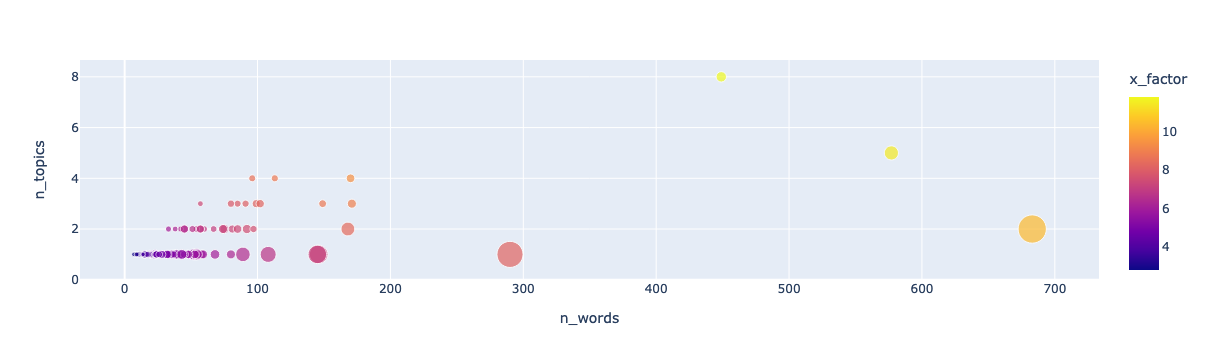

In [73]:
px.scatter(model.PHRASE, 'n_words', 'n_topics', size='topic_weight_mean', color=model.PHRASE.x_factor, hover_name=model.PHRASE.index, width=600)

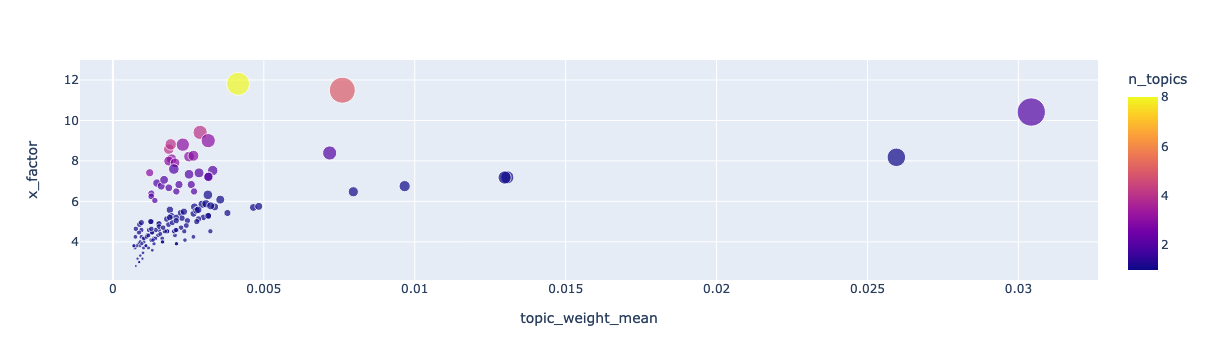

In [72]:
px.scatter(model.PHRASE, 'topic_weight_mean', 'x_factor', color='n_topics', size='n_words',  width=600)

Here is look at the features extracted for topics.

In [28]:
model.TOPIC.head(3).T

topic_id,0,1,2
topic_alpha,0.05072,0.03814,0.08548
topic_words,flavors years tannins oak black blackberry dry...,nose black bottling flavors aromas shows dried...,tannins fruit fruits acidity ripe black struct...
topic_alpha_zscore,-0.214406,-0.863638,1.579496
phrases,"black currant, smoky oak, black cherry, years ...","nose bottling, show nose, sea salt, purple flo...","wood aging, firm tannins, black currant, touri..."
topic_label,00: flavors years tannins oak black blackberry...,01: nose black bottling flavors aromas shows d...,02: tannins fruit fruits acidity ripe black st...
topic_tokens,114874,122102,194825
topic_document_entropy,9.4118,9.1097,9.9299
topic_word_length,5.7,5.5,5.5
topic_coherence,-83.5091,-78.8221,-72.6386
topic_uniform_dist,4.3536,4.0527,4.947


In [25]:
model.TOPIC.sort_values('topic_alpha', ascending=False)[['topic_alpha', 'topic_words', 'phrases']].style.background_gradient()

,topic_alpha,topic_words,phrases
topic_id,,,
6,0.107830,finish cherry flavors black fruit tannins texture notes oak aromas,"black cherry, full bodied, medium bodied, black pepper, black fruit, medium body, long finish, fruit flavors, forest floor, cherry plum"
2,0.085480,tannins fruit fruits acidity ripe black structure rich firm wood,"wood aging, firm tannins, black currant, touriga nacional, black fruits, berry fruits, red fruits, black fruit, aging potential, ripe fruit"
11,0.075590,flavors finish aromas berry plum herbal oak notes blackberry feels,"berry aromas, berry flavors, flavors finish, plum aromas, aromas flavors, plum berry, plum flavors, black cherry, blackberry cassis, berry fruits"
13,0.067980,acidity red light fresh flavors fruity crisp soft bright fruit,"red fruits, crisp acidity, bright acidity, red currant, fresh acidity, red berries, red berry, pinot noir, red fruit, red cherry"
4,0.067100,acidity flavors ripe crisp texture character fruits fruit rich citrus,"crisp acidity, yellow fruits, fruit flavors, ripe fruit, sauvignon blanc, citrus flavors, mineral texture, ripe yellow, bright acidity, premier cru"
15,0.065330,flavors acidity vanilla chardonnay fruit oak pineapple sweet pear peach,"sauvignon blanc, buttered toast, residual sugar, stainless steel, tropical fruit, meyer lemon, apple pear, crme brle, vanilla cream, white peach"
12,0.063470,flavors cherry dry pinot sweet noir cherries cola raspberry red,"pinot noir, high alcohol, raspberry cherry, brown sugar, raspberries cherries, black cherry, pinot noirs, cherry cola, petite sirah, cherry flavors"
9,0.063130,flavors finish aromas apple citrus green melon nose notes fruit,"sauvignon blanc, green apple, aromas flavors, citrus flavors, apple melon, grapefruit flavors, orange peel, citrus aromas, bubble gum, melon citrus"
3,0.058010,fruit flavors finish oak cherry mix tart barrel french vineyard,"fruit flavors, french oak, cherry fruit, pinot noir, months french, stainless steel, baking spices, estate vineyard, walla walla, bottle age"


## Next

Open the db in [DBeaver](https://dbeaver.io/) and explore the model using SQL.